# AIRBNB NOTEBOOK - BOSTON

## Libraries

In [1]:
#Get the Basics
%autosave 60
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import datetime
import time
import pygments

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import folium as fo
import wordcloud as wo
import plotly as plo

#Scaling nicely
from sklearn.preprocessing import StandardScaler

#Models to be used
from sklearn.linear_model import LinearRegression


#Select relevant features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Select best model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

Autosaving every 60 seconds


## Helper functions

In [2]:
def check_data(data):
    for column in data.columns.values:
        print("\n- {} :  \n\tunique values: {}\n\tnull values: {}".format(
              column,
              len(data[column].unique()),
              data[column].isnull().sum()))

def remove_dollar(data):
    data = data.apply(str)
    data = [float(x.strip('$').replace(',','')) for x in data]
    return data

def convert_boolstr(data):
    return data.map(dict(t=1, f=0))

def get_month(date):
    new_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return new_date.strftime("%b")

def get_epoch(date):
    new_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return time.mktime(new_date.timetuple())

def setcolor_by_price(price,price_range):
    if price == 0:
        color = 'lightgrey'
    elif price in price_range.cat.categories[0]:
        color = 'lightred'
    elif price in price_range.cat.categories[1]:
        color = 'red'
    elif price in price_range.cat.categories[2]:
        color = 'darkred'
    else:
        color = 'black'
    return color

## Data Engineering

In [3]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

### Calendar

In [4]:
calendar.shape
calendar.head() 

(1308890, 4)

listing_id        date available price
0    12147973  2017-09-05         f   NaN
1    12147973  2017-09-04         f   NaN
2    12147973  2017-09-03         f   NaN
3    12147973  2017-09-02         f   NaN
4    12147973  2017-09-01         f   NaN

#### Native data state:
- date is at day precision (a bit to much to get something considering 1393570 datapoints
- price contains "$"...
- t/f for a boolean, needs to be converted to 1/0

In [5]:
# Formating calendar data to be useful
calendar.price = remove_dollar(calendar.price)
calendar.available = convert_boolstr(calendar.available)
check_data(calendar)    
calendar.head()
calendar.shape


- listing_id :  
	unique values: 3585
	null values: 0

- date :  
	unique values: 365
	null values: 0

- available :  
	unique values: 2
	null values: 0

- price :  
	unique values: 1247
	null values: 665853


listing_id        date  available  price
0    12147973  2017-09-05          0    NaN
1    12147973  2017-09-04          0    NaN
2    12147973  2017-09-03          0    NaN
3    12147973  2017-09-02          0    NaN
4    12147973  2017-09-01          0    NaN

(1308890, 4)

- 365 unique date values, this is on year timeframe (period 2016-2017)
- There are only 1240 different prices for 3585 unique listings

## Q1 - What is the price evolution over the year ?

In [6]:
calendar_price = calendar  #calendar.loc[calendar['available']==1];
calendar_price['month'] = [get_month(x) for x in calendar_price['date']];
calendar_price = calendar_price.drop(['date'],axis=1);
calendar_price.describe()

listing_id     available          price
count  1.308890e+06  1.308890e+06  643037.000000
mean   8.442118e+06  4.912842e-01     198.438909
std    4.500149e+06  4.999242e-01     180.142913
min    3.353000e+03  0.000000e+00      11.000000
25%    4.679319e+06  0.000000e+00      85.000000
50%    8.578710e+06  0.000000e+00     150.000000
75%    1.279603e+07  1.000000e+00     255.000000
max    1.493346e+07  1.000000e+00    7163.000000

- By converting date format to months reduced dataset size of about 33%
- Price is around 138 dollars with a standard deviation of 105 dollars (some big outlierd of about 10 times the mean)

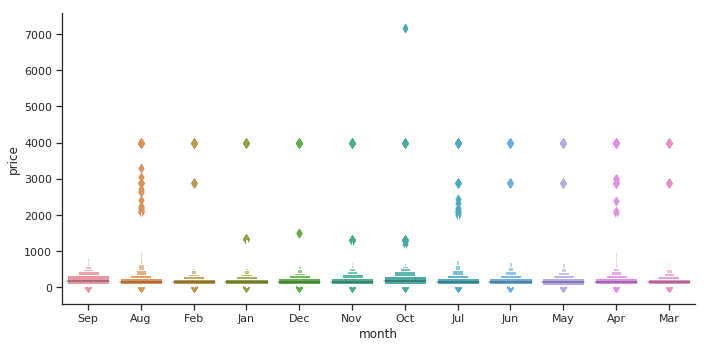

In [7]:
# Display
sns.set(style="ticks",color_codes=True)
sns.catplot(x="month", y="price", kind='boxen', data=calendar_price,height=5,aspect=2);
#price_without_outlier = calendar[calendar_price['price'] < 500];
#sns.catplot(x="month", y="price", kind='boxen', data=price_without_outlier[price_without_outlier['available']==1],height=5,aspect=2);

If we look at the price per month we see larger distributions around summer holidays and some outliers
during winter with price jumps around the year revealing maybe different characteristics / standings

There are the same number of unique listings across the months


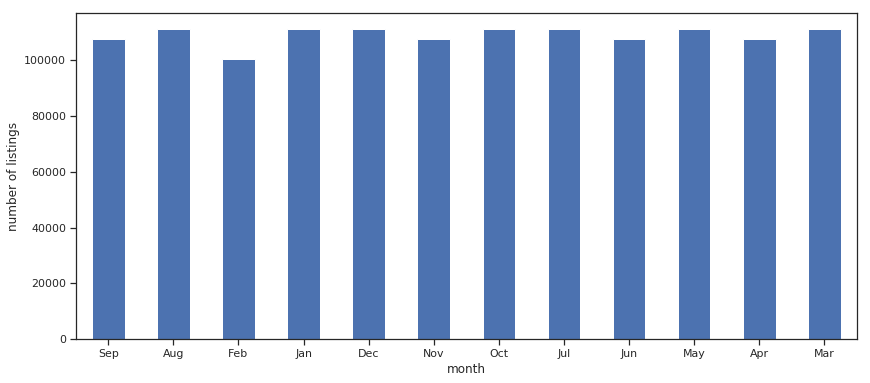

In [8]:
calendar_listings = calendar_price[['month','listing_id']].groupby(['month'],sort=False)['listing_id'].count()
calendar_listings_unique = calendar_price[['month','listing_id']].groupby(['month'],sort=False)['listing_id'].unique()
for element in calendar_listings_unique:
    same_listings =True 
    if len(element) != len(calendar_price['listing_id'].unique()):
        same_listings = False
        break
if same_listings:
    print('There are the same number of unique listings across the months')
sns.set_style()
calendar_listings.head()
ax = calendar_listings.plot.bar(figsize=(14,6),rot=0);
ax.set_ylabel('number of listings');

Property listings varies by about 1% across the year with an all year low around february

Listing of available properties is all year law in January followed July

## Listings

In [9]:
print(listings.shape)
check_data(listings)    
listings.head()

(3585, 95)

- id :  
	unique values: 3585
	null values: 0

- listing_url :  
	unique values: 3585
	null values: 0

- scrape_id :  
	unique values: 1
	null values: 0

- last_scraped :  
	unique values: 1
	null values: 0

- name :  
	unique values: 3504
	null values: 0

- summary :  
	unique values: 3114
	null values: 143

- space :  
	unique values: 2269
	null values: 1057

- description :  
	unique values: 3423
	null values: 0

- experiences_offered :  
	unique values: 1
	null values: 0

- neighborhood_overview :  
	unique values: 1729
	null values: 1415

- notes :  
	unique values: 1270
	null values: 1975

- transit :  
	unique values: 1860
	null values: 1290

- access :  
	unique values: 1763
	null values: 1489

- interaction :  
	unique values: 1618
	null values: 1554

- house_rules :  
	unique values: 1929
	null values: 1192

- thumbnail_url :  
	unique values: 2987
	null values: 599

- medium_url :  
	unique values: 2987
	null values: 599

- picture_url :  
	unique values: 3585
	n

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                               neighborhood_overview  \
0  Roslindale is quiet, convenient and friendly. ...   
1  The room is in Roslindale, a diverse and prima...   
2  The LOCATION: Roslindale is a safe and diverse...   
3  Roslindale is a lovely little neighborhood loc...   
4  I love the proximity to downtown, the neighbor...   

                                               notes  \
0                                                NaN   
1  If you don't have a US cell phone, you can tex...   
2  I am in a scenic part of Boston with a couple ...   
3  Please be mindful of the property as it is old...   
4  I have one roommate who lives on the lower lev...   

                                             transit  \
0  The bus stop is 2 blocks away, and frequent. B...   
1  Plenty of safe street parking. Bus stops a few...   
2  PUBLIC TRANSPORTATION: From the house, quick p...   
3  There are buses that stop right in front of th...   
4  From Logan Airport  and South Station you have...   

                                              access  \
0  You will have access to 2 bedrooms, a living r...   
1  Apt has one more bedroom (which I use) and lar...   
2  I am living in the apartment during your stay,...   
3  The basement has a washer dryer and gym area. ...   
4  You will have access to the front and side por...   

                                         interaction  \
0                                                NaN   
1  If I am at home, I am likely working in my hom...   
2  ABOUT ME: I'm a laid-back, friendly, unmarried...   
3  We do live in the house therefore might be som...   
4  I love my city and really enjoy sharing it wit...   

                                         house_rules  \
0  Clean up and treat the home the way you'd like...   
1  Pet friendly but please confirm with me if the...   
2  I encourage you to use my kitchen, cooking and...   
3  - The bathroom and house are shared so please ...   
4  Please no smoking in the house, porch or on th...   

                                       thumb

In [10]:
# Removing uselss data for column in listings.columns.values:
for column in listings.columns.values:
    if len(listings[column].unique()) == 1:
        listings = listings.drop(column,axis=1)
        print("Removed ",column)

listings.shape
listings.describe()

Removed  scrape_id
Removed  last_scraped
Removed  experiences_offered
Removed  neighbourhood_group_cleansed
Removed  state
Removed  country_code
Removed  country
Removed  has_availability
Removed  calendar_last_scraped
Removed  requires_license
Removed  license
Removed  jurisdiction_names


(3585, 83)

id       host_id  host_listings_count  \
count  3.585000e+03  3.585000e+03          3585.000000   
mean   8.440875e+06  2.492311e+07            58.902371   
std    4.500787e+06  2.292781e+07           171.119663   
min    3.353000e+03  4.240000e+03             0.000000   
25%    4.679319e+06  6.103425e+06             1.000000   
50%    8.577620e+06  1.928100e+07             2.000000   
75%    1.278953e+07  3.622147e+07             7.000000   
max    1.493346e+07  9.385411e+07           749.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                3585.000000  3585.000000  3585.000000   3585.000000   
mean                   58.902371    42.340032   -71.084818      3.041283   
std                   171.119663     0.024403     0.031565      1.778929   
min                     0.000000    42.235942   -71.171789      1.000000   
25%                     1.000000    42.329995   -71.105083      2.000000   
50%                     2.000000    42.345201   -71.078429      2.000000   
75%                     7.000000    42.354685   -71.062155      4.000000   
max                   749.000000    42.389982   -71.000100     16.000000   

         bathrooms     bedrooms         beds  square_feet  guests_included  \
count  3571.000000  3575.000000  3576.000000    56.000000      3585.000000   
mean      1.221647     1.255944     1.609060   858.464286         1.429847   
std       0.501487     0.753060     1.011745   608.874310         1.056787   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       1.000000     1.000000     1.000000   415.000000         1.000000   
50%       1.000000     1.000000     1.000000   825.000000         1.000000   
75%       1.000000     2.000000     2.000000  1200.000000         1.000000   
max       6.000000     5.000000    16.000000  2400.000000        14.000000   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count     3585.000000    3.585000e+03       3585.00000      3585.000000   
mean         3.171269    2.872584e+04          8.64993        21.833194   
std          8.874133    1.670136e+06         10.43533        21.860966   
min          1.000000    1.000000e+00          0.00000         0.000000   
25%          1.000000    3.650000e+02          0.00000         0.000000   
50%          2.000000    1.125000e+03          4.00000        16.000000   
75%          3.000000    1.125000e+03         15.00000        40.000000   
max        300.000000    1.000000e+08         30.00000        60.000000   

       availability_90  availability_365  number_of_reviews  \
count      3585.000000       3585.000000        3585.000000   
mean         38.558159        179.346444          19.044630   
std          33.158272        142.136180          35.571658   
min           0.000000          0.000000           0.000000   
25%           0.000000         19.000000           1.000000   
50%          37.000000        179.000000           5.000000   
75%          68.000000        325.000000          21.000000   
max          90.000000        365.000000         404.000000   

       review_scores_rating  review_scores_accuracy  \
count           2772.000000             2762.000000   
mean              91.916667                9.431571   
std                9.531686                0.931863   
min               20.000000                2.000000   
25%               89.000000                9.000000   
50%               94.000000               10.000000   
75%               98.250000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                2767.000000            2765.000000   
mean                    9.258041               9.646293   
std                     1.168977               0.762753   
min                     2.000000               2.000000   
25%                     9.000000               9.000000   
50%         

In [11]:
# Converting bool and removing dollars
boolean_str =['host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable',
              'require_guest_profile_picture','require_guest_phone_verification']

for column in boolean_str:
    listings[column] = convert_boolstr(listings[column])
    
prices = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for column in prices:
    listings[column] = remove_dollar(listings[column])

In [12]:
# Display
check_data(listings)
listings.shape


- id :  
	unique values: 3585
	null values: 0

- listing_url :  
	unique values: 3585
	null values: 0

- name :  
	unique values: 3504
	null values: 0

- summary :  
	unique values: 3114
	null values: 143

- space :  
	unique values: 2269
	null values: 1057

- description :  
	unique values: 3423
	null values: 0

- neighborhood_overview :  
	unique values: 1729
	null values: 1415

- notes :  
	unique values: 1270
	null values: 1975

- transit :  
	unique values: 1860
	null values: 1290

- access :  
	unique values: 1763
	null values: 1489

- interaction :  
	unique values: 1618
	null values: 1554

- house_rules :  
	unique values: 1929
	null values: 1192

- thumbnail_url :  
	unique values: 2987
	null values: 599

- medium_url :  
	unique values: 2987
	null values: 599

- picture_url :  
	unique values: 3585
	null values: 0

- xl_picture_url :  
	unique values: 2987
	null values: 599

- host_id :  
	unique values: 2181
	null values: 0

- host_url :  
	unique values: 2181
	null values:

(3585, 83)

In [13]:
listings.head()

id                            listing_url  \
0  12147973  https://www.airbnb.com/rooms/12147973   
1   3075044   https://www.airbnb.com/rooms/3075044   
2      6976      https://www.airbnb.com/rooms/6976   
3   1436513   https://www.airbnb.com/rooms/1436513   
4   7651065   https://www.airbnb.com/rooms/7651065   

                                            name  \
0                     Sunny Bungalow in the City   
1              Charming room in pet friendly apt   
2               Mexican Folk Art Haven in Boston   
3  Spacious Sunny Bedroom Suite in Historic Home   
4                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                               neighborhood_overview  \
0  Roslindale is quiet, convenient and friendly. ...   
1  The room is in Roslindale, a diverse and prima...   
2  The LOCATION: Roslindale is a safe and diverse...   
3  Roslindale is a lovely little neighborhood loc...   
4  I love the proximity to downtown, the neighbor...   

                                               notes  \
0                                                NaN   
1  If you don't have a US cell phone, you can tex...   
2  I am in a scenic part of Boston with a couple ...   
3  Please be mindful of the property as it is old...   
4  I have one roommate who lives on the lower lev...   

                                             transit  \
0  The bus stop is 2 blocks away, and frequent. B...   
1  Plenty of safe street parking. Bus stops a few...   
2  PUBLIC TRANSPORTATION: From the house, quick p...   
3  There are buses that stop right in front of th...   
4  From Logan Airport  and South Station you have...   

                                              access  \
0  You will have access to 2 bedrooms, a living r...   
1  Apt has one more bedroom (which I use) and lar...   
2  I am living in the apartment during your stay,...   
3  The basement has a washer dryer and gym area. ...   
4  You will have access to the front and side por...   

                                         interaction  \
0                                                NaN   
1  If I am at home, I am likely working in my hom...   
2  ABOUT ME: I'm a laid-back, friendly, unmarried...   
3  We do live in the house therefore might be som...   
4  I love my city and really enjoy sharing it wit...   

                                         house_rules  \
0  Clean up and treat the home the way you'd like...   
1  Pet friendly but please confirm with me if the...   
2  I encourage you to use my kitchen, cooking and...   
3  - The bathroom and house are shared so please ...   
4  Please no smoking in the house, porch or on th...   

                                       thumbnail_url  \
0  https://a2.muscache.com/im/pictures/c0842db1-e...   
1  https://a1.muscache.com/im/pictures/39327812/d...   
2  https://a2.muscache.com/im/pictures/6ae8335d-9...   
3  https://a2.muscache.com/im/pictures/39764190-1...   
4  https://a1.muscache.com/im/pictures/97154760/8...   

 

## Reviews

In [14]:
print(reviews.shape)
reviews.head()

(68275, 6)


listing_id       id        date  reviewer_id reviewer_name  \
0     1178162  4724140  2013-05-21      4298113       Olivier   
1     1178162  4869189  2013-05-29      6452964     Charlotte   
2     1178162  5003196  2013-06-06      6449554     Sebastian   
3     1178162  5150351  2013-06-15      2215611        Marine   
4     1178162  5171140  2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...

In [15]:
check_data(reviews)    
reviews['date'] = [x[:-3] for x in reviews['date']]


- listing_id :  
	unique values: 2829
	null values: 0

- id :  
	unique values: 68275
	null values: 0

- date :  
	unique values: 2045
	null values: 0

- reviewer_id :  
	unique values: 63789
	null values: 0

- reviewer_name :  
	unique values: 14775
	null values: 0

- comments :  
	unique values: 67312
	null values: 53


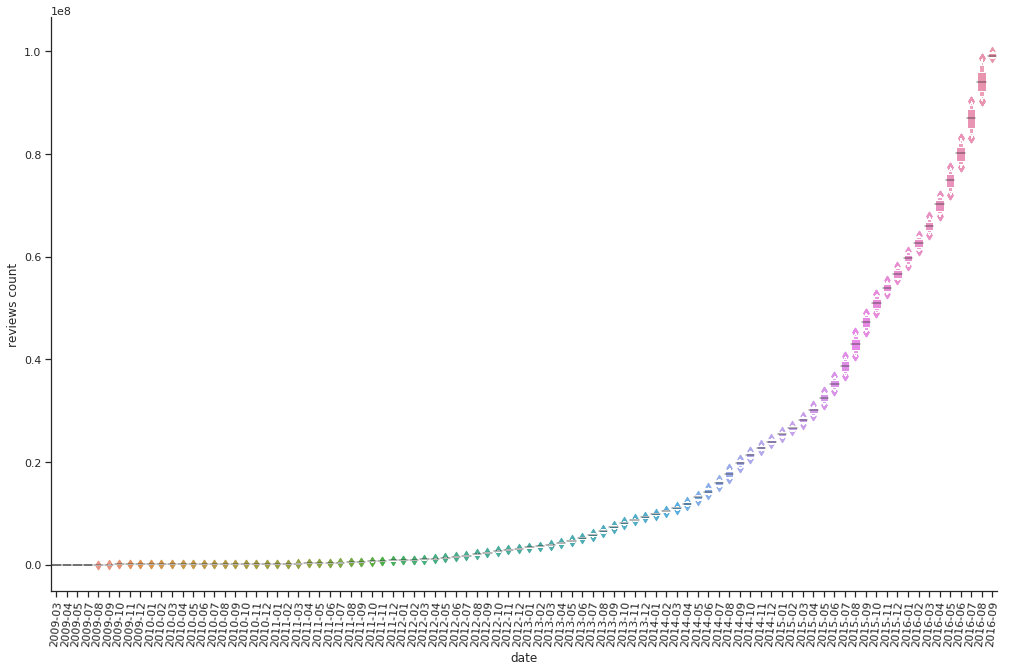

In [16]:
reviews_desc = reviews[['listing_id','id','date']]
reviews_evolution = reviews_desc.groupby(['date']).count()
reviews_evolution.head()
reviews_evolution.shape
sns.set(style="ticks", color_codes=True);
cp = sns.catplot(x="date", y="id", kind='boxen', data=reviews_desc.sort_values('date'),height=5,aspect=2);
cp.set_xticklabels(rotation=85);
cp.fig.set_size_inches(15,10);
cp.ax.set_ylabel('reviews count');

We can see a steep increase of the number of reviews on the full dataset which could be associated to the increasing popularity of AirBnb

In [17]:
listings['id'].describe()
calendar['listing_id'].describe()
#Identical listings

count    3.585000e+03
mean     8.440875e+06
std      4.500787e+06
min      3.353000e+03
25%      4.679319e+06
50%      8.577620e+06
75%      1.278953e+07
max      1.493346e+07
Name: id, dtype: float64

count    1.308890e+06
mean     8.442118e+06
std      4.500149e+06
min      3.353000e+03
25%      4.679319e+06
50%      8.578710e+06
75%      1.279603e+07
max      1.493346e+07
Name: listing_id, dtype: float64

## Q2 - Is it more interesting interesting for short term or long term stay?

In [18]:
listings['price'].isnull().sum()
listings['weekly_price'].isnull().sum()
listings['monthly_price'].isnull().sum()

0

2693

2697

In [19]:
daily_p = listings['price']
weekly_p = listings['weekly_price']
monthly_p = listings['monthly_price']

In [20]:
daily_p = daily_p.astype(float)
weekly_p = weekly_p.astype(float)
monthly_p = monthly_p.astype(float)

d_price_ranges = pd.qcut(daily_p,4)
d_price_ranges.cat.categories
w_price_ranges = pd.qcut(weekly_p,4)
w_price_ranges.cat.categories
m_price_ranges = pd.qcut(monthly_p,4)
m_price_ranges.cat.categories
weekly_p = listings['weekly_price'].fillna(0)
monthly_p = listings['monthly_price'].fillna(0)

IntervalIndex([(9.999, 85.0], (85.0, 150.0], (150.0, 220.0], (220.0, 4000.0]],
              closed='right',
              dtype='interval[float64]')

IntervalIndex([(79.999, 466.75], (466.75, 750.0], (750.0, 1200.0], (1200.0, 5000.0]],
              closed='right',
              dtype='interval[float64]')

IntervalIndex([(499.999, 1600.0], (1600.0, 2925.0], (2925.0, 5000.0], (5000.0, 40000.0]],
              closed='right',
              dtype='interval[float64]')

In [21]:
%%capture
data = listings[['longitude','latitude']];
data['daily_price_color'] = [setcolor_by_price(p,d_price_ranges) 
                             for p in daily_p];
data['weekly_price_color'] = [setcolor_by_price(p,w_price_ranges) 
                              for p in weekly_p];
data['monthly_price_color'] = [setcolor_by_price(p,m_price_ranges) 
                               for p in monthly_p];

In [22]:
%%capture
init = [data['latitude'].mean(),data['longitude'].mean()]
daily_map = fo.Map(location=init,zoom_start=12)
weekly_map = fo.Map(location=init,zoom_start=12)
monthly_map = fo.Map(location=init,zoom_start=12)
data.apply(lambda row:fo.CircleMarker(
                        location=[row["latitude"], row["longitude"]],
                        color=row["daily_price_color"],fill=True,
                        fill_opacity=0.5,
                        opacity=0.4,
                        weight=2,
                        radius=3,
                         ).add_to(daily_map),
                        axis=1)
data.apply(lambda row:fo.CircleMarker(
                        location=[row["latitude"], row["longitude"]],
                        color=row["weekly_price_color"],fill=True,
                        fill_opacity=0.5,
                        opacity=0.4,
                        weight=2,
                        radius=3,
                         ).add_to(weekly_map),
                        axis=1)
data.apply(lambda row:fo.CircleMarker(
                        location=[row["latitude"], row["longitude"]],
                        color=row["monthly_price_color"],fill=True,
                        fill_opacity=0.5,
                        opacity=0.4,
                        weight=2,
                        radius=3,
                         ).add_to(monthly_map),
                        axis=1)

In [23]:
daily_map

In [24]:
weekly_map

In [25]:
monthly_map

We clearly miss data for monthly price and weekly price, as such it seems to be less prone to a monthly rent and more focused on a short term.

[5.52297848]
[87.76476338]
[2.93663398]
[258.34017858]


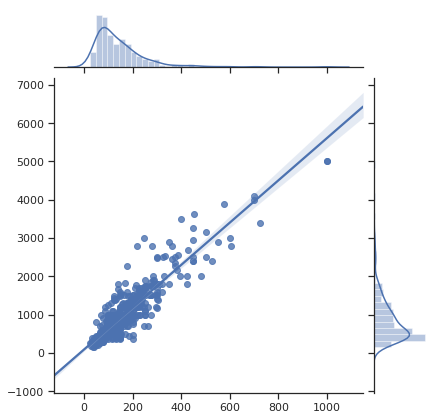

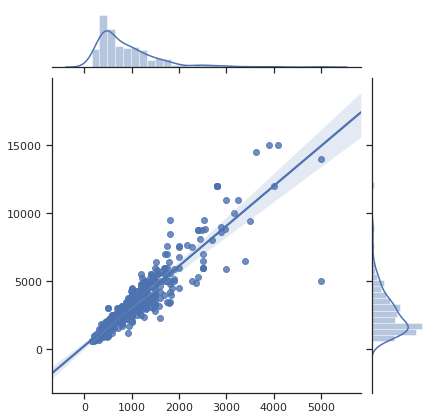

In [26]:
price = listings[['price','weekly_price','monthly_price']].dropna()
from scipy import stats
from sklearn import linear_model

regr = linear_model.LinearRegression();
X = price[['price']]
y = price[['weekly_price']]
regr.fit(X, y);
print(regr.coef_[0])
print(regr.intercept_)

sns.jointplot(price[['price']],price[['weekly_price']],data=price,kind="reg");

regr = linear_model.LinearRegression();
X = price[['weekly_price']]
y = price[['monthly_price']]
regr.fit(X, y);
print(regr.coef_[0])
print(regr.intercept_)
sns.jointplot(price[['weekly_price']],price[['monthly_price']],data=price,kind="reg");

You get about 22% price reduction by staying on a full week (compared to 7 days) and about 25% reduction while staying for a month (compared to 4 weeks)

## Q3 - What does it take to be the best spot in Boston?

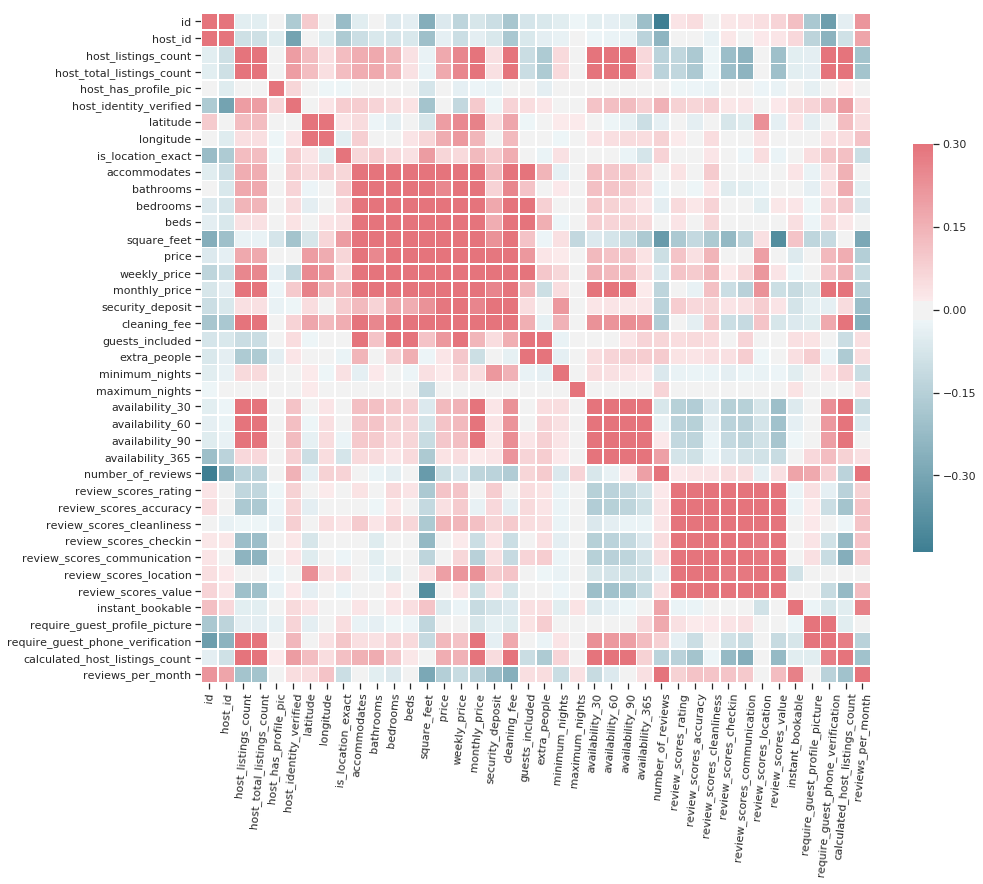

In [27]:
# Compute the correlation matrix
numeric_fields = []
for column in listings.columns.values:
    if listings[column].dtype in ['int64','float64']:
        numeric_fields.append(column)

listings_numerical = listings[numeric_fields]
from sklearn import preprocessing
mima_scaler = preprocessing.MinMaxScaler()
listings_numerical_scaled = mima_scaler.fit_transform(listings_numerical)
listings_numerical_scaled = pd.DataFrame(listings_numerical_scaled,columns=listings_numerical.columns)
corr = listings_numerical_scaled.corr()

#%%
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5});
hm.set_xticklabels(labels=hm.get_xticklabels(),rotation=85);

**Some interesting notes:**
- There is anticorrelation between the number of reviews, review scores value and the number of square feet
- The number of reviews correlates to the exactitude of the location, square feet, cleaning fee, verification requirements and capacity to be bookable

In [28]:
listings_numerical.review_scores_value.mean()
listings_numerical.review_scores_value.std()

9.16823444283647

1.0111164575854912

In [29]:
listing_count_by_host = listings.groupby("host_id")['host_total_listings_count'];

In [30]:
print("Std: ",listing_count_by_host.count().std())
print("Average number of listings: ",listing_count_by_host.count().mean())
print("Maximum number of listings: ",listing_count_by_host.count().max())

Std:  4.270562081377005
Average number of listings:  1.6437414030261348
Maximum number of listings:  136


In [31]:
listings.columns

Index(['id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'zipcode',
       'market', 'smart_location', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
    

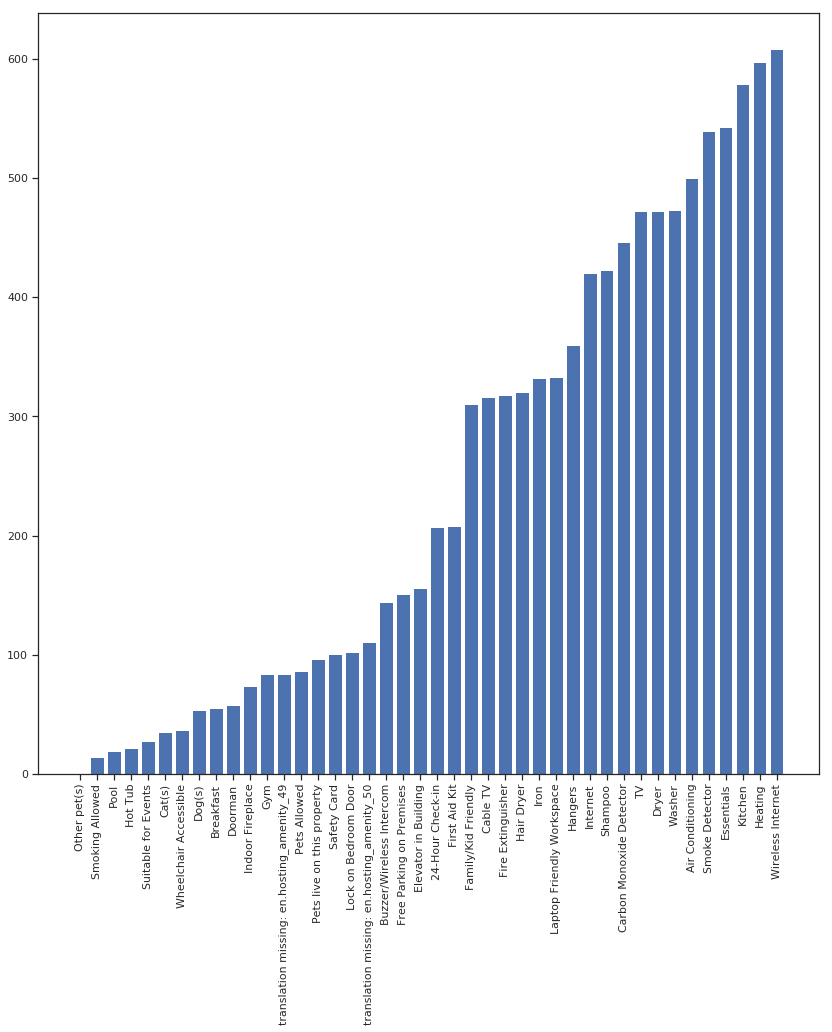

In [32]:
best = listings[listings['review_scores_rating'] == listings['review_scores_rating'].max()]
amenities = dict()
for amenity in best.amenities:
    text = amenity.replace('}','').replace('{','').replace('"','')
    tokens = text.split(',')
    for token in tokens:
        token = token.strip()
        if token != '':
            if token in amenities:
                amenities[token] += 1
            else:
                amenities[token] = 1
            
amenities = {k: v for k,v in sorted(amenities.items(), key=lambda x: x[1])}
plt.figure(figsize=(14,14))
plt.bar(range(len(amenities)),list(amenities.values()),align='center')
plt.xticks(range(len(amenities)),list(amenities.keys()),rotation='vertical');

Top 5 amenities are: 
- Wireless Internet (Wifi is life!), 
- Heating, 
- Kitchen
- Essentials [toilet paper, soap, one towel per guest, one pillow per guest, linens for each guest bed]
- Smoke detector


### Q4. Can we predict price range from property specs?

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import unique_labels
import math as mat

-------------------------
Data sanity check

price    0
dtype: int64

Text(0, 0.5, 'Price')

[100.]
[198.]


0

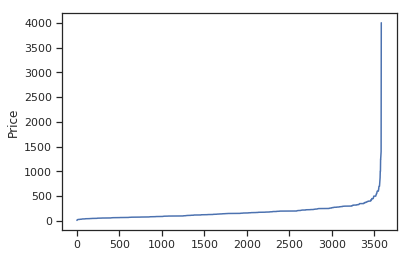

In [72]:
price = listings[['price']]
price.isnull().sum()
price = listings[['price']].sort_values(by='price')
price = price.values
plt.plot(price)
plt.ylabel('Price');
small_price = price[mat.floor(len(price)/3)]
medium_price = price[2*mat.floor(len(price)/3)]
print(small_price)
print(medium_price)

In [73]:
listings['price_range'] = np.nan;
for price in listings['price'].values:
    if price <= small_price:
        listings.loc[listings['price']==price,'price_range'] = 'low'
    elif price <= medium_price:
        listings.loc[listings['price']==price,'price_range'] = 'medium'
    elif price <= 500:
        listings.loc[listings['price']==price,'price_range'] = 'high'
    else:
        listings.loc[listings['price']==price,'price_range'] = 'very high'

In [74]:
bed_types = listings['bed_type'].unique()
property_types = listings['property_type'].unique()
room_types = listings['property_type'].unique()
print(bed_types)
print(property_types)
print(room_types)

['Real Bed' 'Pull-out Sofa' 'Futon' 'Airbed' 'Couch']
['House' 'Apartment' 'Condominium' 'Villa' 'Bed & Breakfast' 'Townhouse'
 'Entire Floor' 'Loft' 'Guesthouse' 'Boat' 'Dorm' 'Other' nan 'Camper/RV']
['House' 'Apartment' 'Condominium' 'Villa' 'Bed & Breakfast' 'Townhouse'
 'Entire Floor' 'Loft' 'Guesthouse' 'Boat' 'Dorm' 'Other' nan 'Camper/RV']


---------------- 
Data Cleaning

In [75]:
listings['num_bed_type'] = listings['bed_type'].astype('category').cat.codes;
listings['num_property_type'] = listings['property_type'].astype('category').cat.codes;
listings['num_room_type'] = listings['room_type'].astype('category').cat.codes;
dataset = listings[['num_property_type','num_room_type','bathrooms','bedrooms','beds','num_bed_type','price_range','latitude','longitude']];
dataset['bathrooms'].fillna(0,inplace=True)
dataset['bedrooms'].fillna(0,inplace=True)
dataset['beds'].fillna(0,inplace=True)
len(dataset)

3585

In [76]:
features = dataset[['num_property_type','num_room_type','bathrooms','bedrooms','beds','num_bed_type','latitude','longitude']];
label = dataset[['price_range']];
train_features, test_features, train_label, test_label = train_test_split(features, label,test_size=0.25);

In [77]:
features = features.astype(float)
features.dtypes

num_property_type    float64
num_room_type        float64
bathrooms            float64
bedrooms             float64
beds                 float64
num_bed_type         float64
latitude             float64
longitude            float64
dtype: object

In [78]:
train_features.isnull().sum()

num_property_type    0
num_room_type        0
bathrooms            0
bedrooms             0
beds                 0
num_bed_type         0
latitude             0
longitude            0
dtype: int64

----------------------
Logistic regression model

In [79]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(train_features,train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [80]:
logreg.predict(test_features);
print("Accuracy is {}".format(logreg.score(train_features,train_label)));

Accuracy is 0.6588541666666666


In [81]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred);

    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if title == None:
        if normalize:
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return cm

In [82]:
from sklearn.metrics import recall_score,precision_score,roc_curve,precision_recall_fscore_support, confusion_matrix, classification_report

#Test classifier
predicted = logreg.predict(test_features)
true = list()
for value in test_label.values:
    true.append(value[0])


                 precision    recall  f1-score   support

      Price low       0.64      0.54      0.58       284
   Price medium       0.78      0.90      0.84       316
     Price high       0.52      0.54      0.53       281
Price very high       0.50      0.06      0.11        16

      micro avg       0.66      0.66      0.66       897
      macro avg       0.61      0.51      0.51       897
   weighted avg       0.65      0.66      0.65       897



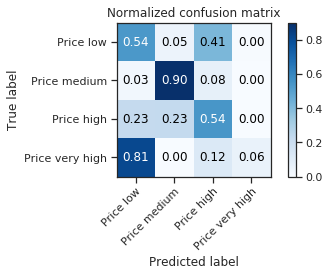

In [83]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
cm = plot_confusion_matrix(true, predicted, classes=['Price low','Price medium','Price high','Price very high'], normalize=True)
print("{}".format(classification_report(true,predicted,target_names=['Price low','Price medium','Price high','Price very high'])))

The model has difficulty to predict high price, and cannot predict very high price has it has a small support.  Overall the accuracy is average, clustering of the prices could be revisited